In [1]:
# Project Goal:

# Build your own recommendation system for products on an e-commerce website like Amazon.com.
# Online E-commerce websites like Amazon, Filpkart uses different recommendation models to provide different suggestions to different users. 
# Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user.
# In this project we are going to build recommendation model for the electronics products of Amazon. 

# The dataset here is taken from the below website. 
# Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)  The repository has several datasets. For this case study, we are using the Electronics dataset.
# Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

# Steps -
# 1. Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)
# 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )
# 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
# 4. Build Popularity Recommender model.
# 5. Build Collaborative Filtering model.
# 6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)
# 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
# 8. Summarise your insights.

In [2]:
# Importing required libraries..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
import warnings; warnings.simplefilter('ignore')

In [3]:
# Data import...column rename...

In [4]:
cols = ['UserID','ItemID','Rating','ProdName']
ds = pd.read_csv('ratings_Electronics.csv',names = cols)

In [5]:
ds.head()

,UserID,ItemID,Rating,ProdName
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
ds.tail()

,UserID,ItemID,Rating,ProdName
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0,1312675200


In [7]:
# Dropping column 'ProdName'...keeping important columns alone..

In [8]:
ds.drop(['ProdName'],axis=1,inplace =True)

In [9]:
# Check the number of rows and columns
rows, columns = ds.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  3


In [10]:
# Finding unique Users & Items...

In [11]:
ds.UserID.unique().shape[0]

4201696

In [12]:
ds.ItemID.unique().shape[0]

476002

In [13]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', ds['UserID'].nunique())
print('Number of unique ITEMS in Raw data = ', ds['ItemID'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


In [14]:
# Data exploration...

In [15]:
ds.dtypes

UserID     object
ItemID     object
Rating    float64
dtype: object

In [16]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
UserID    object
ItemID    object
Rating    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [17]:
ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [18]:
# Check for missing values present
print('Number of missing values across columns-\n', ds.isnull().sum())

Number of missing values across columns-
 UserID    0
ItemID    0
Rating    0
dtype: int64


In [19]:
# So there are no missing values in the dataset...

In [20]:
# find minimum and maximum ratings 

def find_min_max_rating():
    print('The minimum rating is: %d' %(ds['Rating'].min()))
    print('The maximum rating is: %d' %(ds['Rating'].max()))
    
find_min_max_rating()

The minimum rating is: 1
The maximum rating is: 5


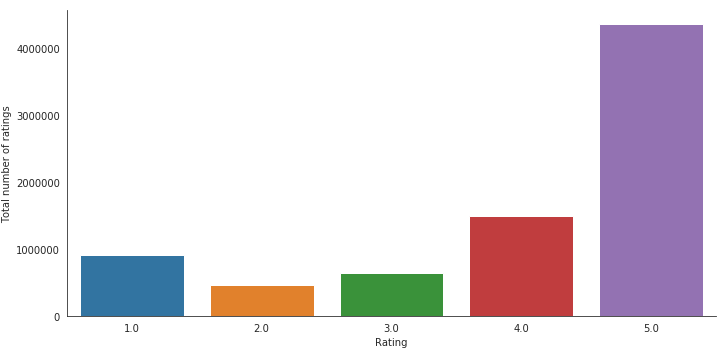

In [21]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=ds, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

In [22]:
# As the dataset is too huge, from the above we know that there are items that are rated only once or few times...
# And we can think of removing those items and reducing the dataset to make is less sparse & more dense...

In [23]:
counts = ds['UserID'].value_counts()
df_final = ds[ds['UserID'].isin(counts[counts >= 100].index)]

In [24]:
print('Number of users who have rated 100 times or more =', len(df_final))
print('Number of unique USERS in final data = ', df_final['UserID'].nunique())
print('Number of unique ITEMS in final data = ', df_final['ItemID'].nunique())

Number of users who have rated 100 times or more = 44209
Number of unique USERS in final data =  289
Number of unique ITEMS in final data =  22635


In [25]:
df_final.head()

,UserID,ItemID,Rating
118,AT09WGFUM934H,0594481813,3.0
178,A17HMM1M7T9PJ1,0970407998,4.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1777,A18S2VGUH9SCV5,1400501776,4.0
2162,A5JLAU2ARJ0BO,1400532655,1.0


In [26]:
#### Calculate the density of the rating matrix

In [27]:
final_ratings_matrix = df_final.pivot(index = 'UserID', columns ='ItemID', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (289, 22635)
given_num_of_ratings =  44209
possible_num_of_ratings =  6541515
density: 0.68%


In [28]:
final_ratings_matrix.tail()

ItemID,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
AY6A8KPYCE6B0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYB4ELCS5AM8P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ515FFZ7I2P7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZAC8O310IK4E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMY6E8B52L2T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserID,A100UD67AHFODS,A100WO06OQR8BQ,A10PEXB6XAQ5XF,A10Y058K7B96C6,A10ZFE6YE0UHW8,A11D1KHM7DVOQK,A11I1I9QLMAM1A,A11KZ906QD08C5,A12DQZKRKTNF5E,A1435P5AMCPB3X,...,AVPNQUVZWMDSX,AWNJAY0M5UI70,AWPODHOB4GFWL,AX05DBU8IRUWY,AX7317G153T8W,AY6A8KPYCE6B0,AYB4ELCS5AM8P,AZ515FFZ7I2P7,AZAC8O310IK4E,AZMY6E8B52L2T
ItemID,,,,,,,,,,,,,,,,,,,,,
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400532655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)

print(train_data.head(5))

                 UserID      ItemID  Rating
5537142   AN81JUYW2SL24  B006ZW4H4C     5.0
3066468   AEWYUPCNDV7HY  B0035FZ124     5.0
1535041  A1U5IJHJK84S54  B000YNVSMW     3.0
3310087  A1ZU55TM45Y2R8  B003ES4NIA     5.0
1188838   AGOH8N902URMW  B000N29KOW     5.0


In [31]:
def shape():
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape()

Test data shape:  (13263, 3)
Train data shape:  (30946, 3)


In [32]:
### Build Popularity Recommender model. (Non-personalised)

In [33]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ItemID').agg({'UserID': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserID': 'score'},inplace=True)
train_data_grouped.head()

,ItemID,score
0,0594481813,1
1,0970407998,1
2,0972683275,1
3,1400501776,1
4,1400532655,2


In [34]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'ItemID'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,ItemID,score,Rank
14029,B0088CJT4U,57,1.0
13912,B00829TIEK,39,2.0
8342,B002R5AM7C,36,3.0
9322,B003ES5ZUU,36,4.0
14131,B008DWCRQW,35,5.0


In [35]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [36]:
find_recom = [50,100,200]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 50

       UserID      ItemID  score  Rank
14029      50  B0088CJT4U     57   1.0
13912      50  B00829TIEK     39   2.0
8342       50  B002R5AM7C     36   3.0
9322       50  B003ES5ZUU     36   4.0
14131      50  B008DWCRQW     35   5.0


Here is the recommendation for the userId: 100

       UserID      ItemID  score  Rank
14029     100  B0088CJT4U     57   1.0
13912     100  B00829TIEK     39   2.0
8342      100  B002R5AM7C     36   3.0
9322      100  B003ES5ZUU     36   4.0
14131     100  B008DWCRQW     35   5.0


Here is the recommendation for the userId: 200

       UserID      ItemID  score  Rank
14029     200  B0088CJT4U     57   1.0
13912     200  B00829TIEK     39   2.0
8342      200  B002R5AM7C     36   3.0
9322      200  B003ES5ZUU     36   4.0
14131     200  B008DWCRQW     35   5.0




In [37]:
print('Since this is a popularity-based recommender model, recommendations remain the same for all users')
print('\nWe predict the products based on the popularity. It is not personalized to particular user')

Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user


In [38]:
### Build Collaborative Filtering model.

In [39]:
#### Model-based Collaborative Filtering: Singular Value Decomposition

In [40]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

,index,UserID,ItemID,Rating
44204,7760561,A2NOW4U7W3F7RI,B00HPPI0W8,5.0
44205,7755693,A25C2M3QF9G7OQ,B00HLAGR0E,5.0
44206,5280685,A6VXZ1EEPRTLV,B0062EUE54,5.0
44207,1715585,A3PD8JD9L4WEII,B0015DYMVO,5.0
44208,1015054,A3T7V207KRDE2O,B000HX1P8G,3.0


In [41]:
# User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'UserID', columns ='ItemID', values = 'Rating').fillna(0)
print(pivot_df.shape)
pivot_df.head()

(289, 22635)


ItemID,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ZFE6YE0UHW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ItemID,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10ZFE6YE0UHW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [43]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

ItemID,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
### SVD method
### SVD is best to apply on a large sparse matrix...

In [45]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [46]:
### Note that for sparse matrices, you can use the sparse.linalg.svds() function to perform the decomposition.
## SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and 
## Latent Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining

In [47]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ItemID,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.007273,0.001249,-0.024354,0.019858,0.007163,0.000739,0.012744,0.018462,0.005363,-0.003601,...,-0.055311,0.322925,-0.005588,-0.077080,-0.141806,-0.131544,0.013394,-0.198731,0.067938,0.001584
1,0.002485,-0.002452,0.057358,0.040406,-0.004640,0.000436,0.014649,0.013111,-0.000113,0.010802,...,0.006710,-0.105079,-0.009598,0.048149,0.026633,-0.012872,-0.029599,-0.022377,-0.034546,0.008466
2,0.000950,0.000487,0.119640,0.002175,0.000435,0.000086,-0.011196,0.014611,0.000064,-0.007642,...,-0.037576,0.235628,0.019401,-0.000993,0.103821,-0.040986,0.039064,0.084783,-0.038712,0.037797
3,-0.004321,-0.001464,0.105522,0.038826,-0.006237,-0.000095,-0.052618,-0.005630,0.005933,0.017571,...,-0.044521,0.123957,0.019767,0.044702,0.021392,-0.113093,0.015574,0.173706,-0.042632,-0.032504
4,0.008672,0.002921,0.079571,0.018170,-0.003324,0.000593,0.055773,0.017284,0.004907,0.015156,...,-0.055204,0.177769,0.001409,0.128439,0.052704,-0.059792,-0.016654,0.051093,-0.051577,-0.014446


In [48]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(UserID = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [49]:
pivot_df.iloc[120].sort_values(ascending=False)

ItemID
B0045FM6SU    5.0
B001MJX4MO    5.0
B008O6CGAO    5.0
B005KMOK6I    5.0
B0063E3ZPO    5.0
B001MT8J4W    5.0
B004DBIKOK    5.0
B008DH4XJQ    5.0
B003CFATT2    5.0
B00D429Y12    5.0
B004H0OA7S    5.0
B00B0GAQ34    5.0
B005HY4UPK    5.0
B001OOZU8I    5.0
B0051V7XK8    5.0
B00EVIBN8U    5.0
B00ITI04YM    5.0
B00BF9MUAS    5.0
B00CB2F65O    5.0
B002DYGQI6    5.0
B008EQZ25K    5.0
B004ZAZMKE    5.0
B002QC17VG    5.0
B003M0NURK    5.0
B0028Y4H1O    5.0
B0028Y4H0K    5.0
B009AEMB6I    5.0
B00FF8ZRR8    5.0
B006YTZUA6    5.0
B007DJGHH6    5.0
             ... 
B004Z4JF94    0.0
B004Z50L6E    0.0
B004Z55VP0    0.0
B004Z57WDO    0.0
B004Z57X42    0.0
B004Z57XFQ    0.0
B004Z57XPQ    0.0
B004YW6I38    0.0
B004YVS7T2    0.0
B004YLCE2S    0.0
B004YLCO64    0.0
B004YLCFCM    0.0
B004YLCGBC    0.0
B004YLCH0C    0.0
B004YLCHLQ    0.0
B004YLCIC4    0.0
B004YLCKYA    0.0
B004YLCLM6    0.0
B004YLCN1U    0.0
B004YLGFYQ    0.0
B004YUIW1Q    0.0
B004YM6FFY    0.0
B004YMCXVO    0.0
B004YNE7V2    0.0
B00

In [50]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 100
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(UserID = 100):

                   user_ratings  user_predictions
Recommended Items                                
B004CLYEDC                  0.0          2.348629
B002R5AM7C                  0.0          1.126951
B0079UAT0A                  0.0          1.096550
B00829TIEK                  0.0          1.022568
B00834SJSK                  0.0          0.966522


In [51]:
## Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on 
## predictions made on the test data.)

In [52]:
#### Evaluation of Model-based Collaborative Filtering (SVD)

In [53]:
# Actual ratings given by the users
final_ratings_matrix.head()

ItemID,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ZFE6YE0UHW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ItemID
0594481813    0.010381
0970407998    0.013841
0972683275    0.017301
1400501776    0.013841
1400532655    0.013841
dtype: float64

In [55]:
# Predicted ratings 
preds_df.head()

ItemID,0594481813,0970407998,0972683275,1400501776,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,...,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.007273,0.001249,-0.024354,0.019858,0.007163,0.000739,0.012744,0.018462,0.005363,-0.003601,...,-0.055311,0.322925,-0.005588,-0.077080,-0.141806,-0.131544,0.013394,-0.198731,0.067938,0.001584
1,0.002485,-0.002452,0.057358,0.040406,-0.004640,0.000436,0.014649,0.013111,-0.000113,0.010802,...,0.006710,-0.105079,-0.009598,0.048149,0.026633,-0.012872,-0.029599,-0.022377,-0.034546,0.008466
2,0.000950,0.000487,0.119640,0.002175,0.000435,0.000086,-0.011196,0.014611,0.000064,-0.007642,...,-0.037576,0.235628,0.019401,-0.000993,0.103821,-0.040986,0.039064,0.084783,-0.038712,0.037797
3,-0.004321,-0.001464,0.105522,0.038826,-0.006237,-0.000095,-0.052618,-0.005630,0.005933,0.017571,...,-0.044521,0.123957,0.019767,0.044702,0.021392,-0.113093,0.015574,0.173706,-0.042632,-0.032504
4,0.008672,0.002921,0.079571,0.018170,-0.003324,0.000593,0.055773,0.017284,0.004907,0.015156,...,-0.055204,0.177769,0.001409,0.128439,0.052704,-0.059792,-0.016654,0.051093,-0.051577,-0.014446


In [56]:
# Average PREDICTED rating for each item
preds_df.mean().head()

ItemID
0594481813    0.003906
0970407998    0.008070
0972683275    0.028863
1400501776    0.013726
1400532655    0.007880
dtype: float64

In [57]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(22635, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ItemID,,,
0594481813,0.010381,0.003906,0
0970407998,0.013841,0.008070,1
0972683275,0.017301,0.028863,2
1400501776,0.013841,0.013726,3
1400532655,0.013841,0.007880,4


In [58]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.009 



In [59]:
# Since we get very less RMSE for the SVD model we can conclude that our model accuracy will be high...

In [60]:
### Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, 
## we will recommend 5 new products.

In [61]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 200
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(UserID = 200):

                   user_ratings  user_predictions
Recommended Items                                
B008X9ZBVI                  0.0          4.790933
B004CLYEH8                  0.0          2.944953
B00A3YDKRI                  0.0          2.552130
B008ULPCB8                  0.0          2.522813
B00AYTW80M                  0.0          2.449210


In [62]:
## Conclusion:
## Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior
## of the user and it is not dependent on any additional information.
## The Popularity-based recommender system is non-personalised and the recommendations are based on frequency counts, which may 
## be not suitable to the user.You can see the differance above for the user id 100 & 200, The Popularity based model has 
## recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list
## based on the user past purchase history. Although user ratings for those top 5 products is 0..since we are looking only 
## based on user past purchase history and not based on user ratings for those products...
## since we got very less RMSE for the SVD model we can conclude that our model has high accuracy recommendation engine to 
## recommend products for the users...
## Thus we have covered all the projects goals and steps for the recommendation engine using the amazon electronics product
## data set.